# Azure AI Content Understanding - Classifier and Analyzer Demo

This notebook demonstrates how to use Azure AI Content Understanding service to:
1. Create a classifier to categorize documents
2. Create a custom analyzer to extract specific fields
3. Combine classifier and analyzers to classify, optionally split, and analyze documents in a flexible processing pipeline

If you’d like to learn more before getting started, see the official documentation:
[Understanding Classifiers in Azure AI Services](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/concepts/classifier)

## Prerequisites
1. Ensure Azure AI service is configured following [steps](../README.md#configure-azure-ai-service-resource)
2. Install the required packages to run the sample.


In [1]:
# %pip install -r requirements.txt

## 1. Import Required Libraries

In [2]:
import json
import logging
import os
import sys
import uuid
from pathlib import Path

from dotenv import find_dotenv, load_dotenv
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

load_dotenv(find_dotenv())
logging.basicConfig(level=logging.INFO)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Import Azure Content Understanding Client

The `AzureContentUnderstandingClient` class handles all API interactions with the Azure AI service.

In [3]:
try:
    from content_understanding_client import AzureContentUnderstandingClient
    print("✅ Azure Content Understanding Client imported successfully!")
except ImportError:
    print("❌ Error: Make sure 'AzureContentUnderstandingClient.py' is in the same directory as this notebook.")
    raise

✅ Azure Content Understanding Client imported successfully!


## 3. Configure Azure AI Service Settings and Prepare the Sample

Update these settings to match your Azure environment:

- **AZURE_AI_ENDPOINT**: Your Azure AI service endpoint URL or set up in ".env" file
- **AZURE_AI_API_VERSION**: The Azure AI API version to use. Default is "2025-05-01-preview". 
- **AZURE_AI_API_KEY**: Your Azure AI service key (optional if using token authentication)
- **SAMPLE_CLAIMS_BUNDLE**: Path to the PDF document you want to process

In [4]:
# always refresh all vars
load_dotenv(override=True)
# For authentication, you can use either token-based auth or subscription key, and only one of them is required
AZURE_AI_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")
# IMPORTANT: Replace with your actual subscription key or set up in ".env" file if not using token auth
AZURE_AI_API_KEY = os.getenv("AZURE_CONTENT_UNDERSTANDING_SUBSCRIPTION_KEY")
AZURE_AI_API_VERSION = os.getenv("AZURE_AI_API_VERSION", "2025-05-01-preview")
SAMPLE_CLAIMS_BUNDLE = os.getenv("SAMPLE_CLAIMS_BUNDLE")
# Authentication - Using DefaultAzureCredential for token-based auth
# Using the current users identity here

# Setup credentials
credential = DefaultAzureCredential(
    exclude_managed_identity_credential=True,
    exclude_client_secret_credential=True,
    exclude_environment_credential=True,
    exclude_workload_identity_credential=True,
    exclude_shared_token_cache_credential=True,
    exclude_azure_powershell_credential=True,
    exclude_azure_developer_cli_credential=True,
)
token_provider = get_bearer_token_provider(credential, "https://cognitiveservices.azure.com/.default")

file_location = Path(SAMPLE_CLAIMS_BUNDLE)

print("📋 Configuration Summary:")
print(f"   Endpoint: {AZURE_AI_ENDPOINT}")
print(f"   API Version: {AZURE_AI_API_VERSION}")
#print(f"   API KEY: {AZURE_AI_API_KEY}")
print(f"   Document: {file_location.name if file_location.exists() else '❌ File not found'}")

📋 Configuration Summary:
   Endpoint: https://wwawilk-cu-ai-service.openai.azure.com/
   API Version: 2025-05-01-preview
   Document: sample claim submission.pdf


## 4. Define Classifier Schema

The classifier schema defines:
- **Categories**: Document types to classify (e.g., Legal, Medical)
  - **description (Optional)**: An optional field used to provide additional context or hints for categorizing or splitting documents. This can be helpful when the category name alone isn’t descriptive enough. If the category name is already clear and self-explanatory, this field can be omitted.

- **This classifier should indtify these document types**
  -  **Completed_Claim_Form**  
  -   **HIPAA_Release**  
  -   **Signed_Physician_Statement**  
  -   **Pathology_Report**  
  -   **Doctor_Office_Visit_Report**  
  -   **Scanner_Report**  
  -   **Other_Document_Type**
  -   **Itemized_Bill_for_Lab_Services**  
  -   **Itemized_Bill_for_Radiology_Services**  
  -   **Itemized_Bill_from_Other_Service_Providers_Type**  
  -   **UB04_Bil** 

- **splitMode Options**: Defines how multi-page documents should be split before classification or analysis.
  - `"auto"`: Automatically split based on content.  
  For example, if two categories are defined as “invoice” and “application form”:
    - A PDF with only one invoice will be classified as a single document.
    - A PDF containing two invoices and one application form will be automatically split into three classified sections.
  - `"none"`: No splitting.  
  The entire multi-page document is treated as a single unit for classification and analysis.
  - `"perPage"`: Split by page.  
  Each page is treated as a separate document. This is useful when you’ve built custom analyzers designed to operate on a per-page basis.

  ### Below is my schema definition

In [5]:
# I am automatically splitting by document based on content! That means per document within the bundle
# Define field descriptions and classifier document categories and their descriptions
classifier_schema = {
			"categories": {
					"Completed_Claim_Form": {"description": "a Completed Claim Form"},
					"HIPAA_Release": {"description": "a HIPAA Release"},
					"Signed_Physician_Statement": {"description": "a Signed Physician Statement"},
                    "Itemized_Bill_for_Lab_Services": {"description": "an Itemized Bill from a laboratory for Lab test and services. This type which includes Statments, Invoices, Account Summaries, any document that has dollar amounts on it sent from a lab"},
					"Itemized_Bill_for_Radiology_Services": {"description": "an Itemized Bill from a radiology department for imaging services. This type which includes Statments, Invoices, Account Summaries, any document that has dollar amounts on it sent from a radiology provider."},
                    "Itemized_Bill_from_Other_Service_Providers_Type": {"description": "an Itemized Bill from a other than a laboratory, a radiology provider or a hospitals provider types listed above This type which includes Statments, Invoices, Account Summaries, any document that has dollar amounts on it."},
					"UB04_Bill": {"description": "A special type of itemized bill. It will have the notation on it UB04 or UB-04 or UB 04."},
					"Pathology_Report": {"description": "a Pathology Report"},
                    "Doctor_Office_Visit_Report": {"description": "a Doctor Office Visit Report contains a narrative of the visit, including symptoms, diagnosis, and treatment plan. It does not include any billing information."},
                    "Scanner_Report": {"description": "a Scanner Report that list issue with the scan of the documents"},
					"Other_Document_Type": {"description": "A document type other the other ones specified"}
					},
    			"splitMode": "auto"  # IMPORTANT: Automatically detect document boundaries. Can change mode for your needs.
			}
			

# just listing out my doc types here
print("📄 Classifier DocTypes:")
for category, details in classifier_schema["categories"].items():
    print(f"   • {category}: {details['description'][:60]}...")

📄 Classifier DocTypes:
   • Completed_Claim_Form: a Completed Claim Form...
   • HIPAA_Release: a HIPAA Release...
   • Signed_Physician_Statement: a Signed Physician Statement...
   • Itemized_Bill_for_Lab_Services: an Itemized Bill from a laboratory for Lab test and services...
   • Itemized_Bill_for_Radiology_Services: an Itemized Bill from a radiology department for imaging ser...
   • Itemized_Bill_from_Other_Service_Providers_Type: an Itemized Bill from a other than a laboratory, a radiology...
   • UB04_Bill: A special type of itemized bill. It will have the notation o...
   • Pathology_Report: a Pathology Report...
   • Doctor_Office_Visit_Report: a Doctor Office Visit Report contains a narrative of the vis...
   • Scanner_Report: a Scanner Report that list issue with the scan of the docume...
   • Other_Document_Type: A document type other the other ones specified...


## 5. Initialize Content Understanding Client

Create the client that will communicate with Azure AI services.

⚠️ Important:
You must update the code below to match your Azure authentication method.
Look for the `# IMPORTANT` comments and modify those sections accordingly.
If you skip this step, the sample may not run correctly.

⚠️ Note: Using a subscription key works, but using a token provider with Azure Active Directory (AAD) is much safer and is highly recommended for production environments.

In [6]:
# Initialize the Azure Content Understanding client
try:
    content_understanding_client = AzureContentUnderstandingClient(
        endpoint=AZURE_AI_ENDPOINT,
        api_version=AZURE_AI_API_VERSION,
        # IMPORTANT: Comment out token_provider if using subscription key
        token_provider=token_provider,
        # IMPORTANT: Uncomment this if using subscription key
        subscription_key=AZURE_AI_API_KEY,
    )
    print("✅ Content Understanding client initialized successfully!")
    print("   Ready to create classifiers and analyzers.")
except Exception as e:
    print(f"❌ Failed to initialize client: {e}")
    raise

INFO:azure.identity._credentials.chained:DefaultAzureCredential acquired a token from AzureCliCredential


✅ Content Understanding client initialized successfully!
   Ready to create classifiers and analyzers.


## 9A. Create a Custom Analyzer (9A) for the itemizated bill doc types

Now let's create a schenma for custom analyzer that can extract specific fields from documents.
This analyzer will:
- Extract common document fields from the Medical and billing documents in the bundle


In [7]:
# Define analyzer schema with custom fields
analyzer_schema_9A = {
    "description": "Analyzer_with_document_fields - extracts key document information from a bundle of documents in a single pdf submitted for claims",
    "baseAnalyzerId": "prebuilt-documentAnalyzer",  # Built on top of the general document analyzer
    "config": {
        "returnDetails": True,
        "enableLayout": True,          # Extract layout information
        "enableBarcode": False,        # Skip barcode detection
        "enableFormula": False,        # Skip formula detection
        "estimateFieldSourceAndConfidence": True, # Set to True if you want to estimate the field location (aka grounding) and confidence
        "disableContentFiltering": False,
    },
    "fieldSchema": {
        "fields": {
			"title_on_first_page_of_document": {
				"type": "string",
				"method": "generate",
				"description": "This is the title of the document. It will typically be the line of text with the largest sized font near the top of the page The value should be \"None\" if there is no title or it cannot be determined. "
			}
        }
    }
}

# Generate unique analyzer ID
analyzer_id_9A = "Analyzer_with_document_fields_9A_" + str(uuid.uuid4())

# Create the analyzer
try:
    print(f"🔨 Creating custom analyzer: {analyzer_id_9A}")
    print("\n📋 Analyzer will extract:")
    for field_name, field_info in analyzer_schema_9A["fieldSchema"]["fields"].items():
        print(f"   • {field_name}: {field_info['description']}")
    
    response = content_understanding_client.begin_create_analyzer(analyzer_id_9A, analyzer_schema_9A)
    result = content_understanding_client.poll_result(response)
    
    # just printing the fields created
    print("\n✅ Analyzer_with_document_fields created successfully!")
    print(f"   Analyzer ID 9A: {analyzer_id_9A}")
    
except Exception as e:
    print(f"\n❌ Error creating analyzer: {e}")
    analyzer_id_9A = None  # Set to None if creation failed

🔨 Creating custom analyzer: Analyzer_with_document_fields_9A_51093fbe-35b5-4ac7-98ea-3e6a7e5d79ca

📋 Analyzer will extract:
   • title_on_first_page_of_document: This is the title of the document. It will typically be the line of text with the largest sized font near the top of the page The value should be "None" if there is no title or it cannot be determined. 


INFO:content_understanding_client:Analyzer Analyzer_with_document_fields_9A_51093fbe-35b5-4ac7-98ea-3e6a7e5d79ca create request accepted.
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:content_understanding_client:Request 7d9b2541-51b7-4e3b-9eb7-72968b0f2ed7 in progress ...
INFO:co


✅ Analyzer_with_document_fields created successfully!
   Analyzer ID 9A: Analyzer_with_document_fields_9A_51093fbe-35b5-4ac7-98ea-3e6a7e5d79ca


## 9B. And a Custom Analyzer (9B) for the billed expenses

In [8]:
# Define analyzer schema with custom fields
analyzer_schema_9B = {
    "description": "Analyzer_with_document_fields - extracts key document information from a bundle of documents in a single pdf submitted for claims",
    "baseAnalyzerId": "prebuilt-documentAnalyzer",  # Built on top of the general document analyzer
    "config": {
        "returnDetails": True,
        "enableLayout": True,          # Extract layout information
        "enableBarcode": False,        # Skip barcode detection
        "enableFormula": False,        # Skip formula detection
        "estimateFieldSourceAndConfidence": True, # Set to True if you want to estimate the field location (aka grounding) and confidence
        "disableContentFiltering": False,
    },
    "fieldSchema": {
        "fields": {
			"title_on_first_page_of_document": {
				"type": "string",
				"method": "generate",
				"description": "This is the title of the document. It will typically be the line of text with the largest sized font near the top of the page The value should be \"None\" if there is no title or it cannot be determined. "
			},
			"Expenses": {
				"type": "array",
				"items": {
					"type": "object",
					"properties": {
                        "Expense_Amount": {
                                "type": "number",
                                "method": "generate",
                                "description": "A table of the expense items amounts billed to patient or insurance company. These are charges for procedures, professional services, lab tests performed and other medical services. They will be numeric with 2 decimal places. Keep the 2 decimal places even it they are .00. They will typically be on the document pages in a tabular layout with the expensed dollar amounts all in the same column. You will typically find the other columns to extract ICD code CPT code etc for the other columns in this table usually on the same line as the amount. Only capture positive amounts that are actual charges (not totals, subtotals, adjustments, refunds, or negative values or amount that are zero). All dollar amounts for expenses must be captured. the document may contain multiple pages of expenses within a single document."
                            },
                            "ICD_Code": {
                                "type": "string",
                                "method": "generate",
                                "description": "The ICD code associated with the expense if there is one. If there is no ICD code, use \"\".  The ICD code is usually on the same line of the table as the amount"
                            },
                            "Date": {
                                "type": "date",
                                "method": "generate",
                                "description": "The date of the expense. The date is usually on the same line of the table as the amount format the date as mm/dd/yyyy."
                            },
                            "Expense_Description": {
                                "type": "string",
                                "method": "generate",
                                "description": "The description of the expense. This may be the procedure name. It is usually on the same line of the table as the amount."	
                            },
                            "Surgeon_Name_or_Provider": {
                                "type": "string",
                                "method": "generate",
                                "description": "The surgeon or provider if this expense was a sugical procedure."
                            },
                            "CPT_Code": {
                                "type": "string",
                                "method": "generate",
                                "description": "The CPT code associated with the expense.  It is usually on the same line of the table as the amount."	
                            },
                            "Ref_Page": {
                                "type": "number",
                                "method": "generate",
                                "description": "The Bundle page the expense was found on. This is the page number from the top of the page in tha stamped header. It will on the line of text that starts with Page XX of YY where xx  is the current page number and yy is the total number of pages in the document bundle."
                            },
                            "Drug_Name": {
                                "type": "string",
                                "method": "generate",
                                "description": "If the expense charge was for a drug, put the drug name here. If not for a drug put N/A in this field."
                            },
                            "Expense_Type": {
                                "type": "string",
                                "method": "generate",
                                "description": "Categorize each expense into one of four categories based on the description, ICD10, CPT code, or other context. The 4 categories are:  1. Cancer_History_Expenses, 2. Diagnostic_Tests_and_Labs_Expenses,  3. Surgical_Events_Expenses,  4. Cancer_Treatment_Expenses. Put every expense into one of the four. If it was for a exam, a lab test or other diagostic test that diagosed cancer or remission, make it a #1. it was for a lab or dignostic test make it a #2 If it was for a surgical procedure make it a #3. Everything else is a #4. use the full name not just the number when filling in field."
                            }
                        },
                        "method": "generate"
                    },
				"method": "generate",
				"description": "Expenses are charges billed to either the patient or insurance company. They are single charges for a procedure, test or other medical service. They do not include payments, adjustments, refunds, total balances, subtotals. Other than these exceptions all other dollar amounts may be an expense and should be reviewed."
                }
            },
        }
}

# Generate unique analyzer ID
analyzer_id_9B = "Analyzer_with_document_fields_9B_" + str(uuid.uuid4())

# Create the analyzer
try:
    print(f"🔨 Creating custom analyzer: {analyzer_id_9B}")
    print("\n📋 Analyzer will extract:")
    for field_name, field_info in analyzer_schema_9B["fieldSchema"]["fields"].items():
        print(f"   • {field_name}: {field_info['description']}")

    response = content_understanding_client.begin_create_analyzer(analyzer_id_9B, analyzer_schema_9B)
    result = content_understanding_client.poll_result(response)
    
    # just printing the fields created
    print("\n✅ Analyzer_with_document_fields created successfully!")
    print(f"   Analyzer ID: {analyzer_id_9B}")

except Exception as e:
    print(f"\n❌ Error creating analyzer: {e}")
    analyzer_id_9B = None  # Set to None if creation failed

🔨 Creating custom analyzer: Analyzer_with_document_fields_9B_d4307c75-9f05-4150-a7b7-db0bf3331830

📋 Analyzer will extract:
   • title_on_first_page_of_document: This is the title of the document. It will typically be the line of text with the largest sized font near the top of the page The value should be "None" if there is no title or it cannot be determined. 
   • Expenses: Expenses are charges billed to either the patient or insurance company. They are single charges for a procedure, test or other medical service. They do not include payments, adjustments, refunds, total balances, subtotals. Other than these exceptions all other dollar amounts may be an expense and should be reviewed.


INFO:content_understanding_client:Analyzer Analyzer_with_document_fields_9B_d4307c75-9f05-4150-a7b7-db0bf3331830 create request accepted.
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:content_understanding_client:Request e92c1cdc-acd8-40cf-8e00-d745cc9bc5eb in progress ...
INFO:co


✅ Analyzer_with_document_fields created successfully!
   Analyzer ID: Analyzer_with_document_fields_9B_d4307c75-9f05-4150-a7b7-db0bf3331830


## 9C. And a Custom Analyzer (9C) for the patient information

In [9]:
# Define analyzer schema with custom fields
analyzer_schema_9C = {
    "description": "Analyzer_with_document_fields - extracts key document information from a bundle of documents in a single pdf submitted for claims",
    "baseAnalyzerId": "prebuilt-documentAnalyzer",  # Built on top of the general document analyzer
    "config": {
        "returnDetails": True,
        "enableLayout": True,          # Extract layout information
        "enableBarcode": False,        # Skip barcode detection
        "enableFormula": False,        # Skip formula detection
        "estimateFieldSourceAndConfidence": True, # Set to True if you want to estimate the field location (aka grounding) and confidence
        "disableContentFiltering": False,
    },
    "fieldSchema": {
        "fields": {
			"title_on_first_page_of_document": {
				"type": "string",
				"method": "generate",
				"description": "This is the title of the document. It will typically be the line of text with the largest sized font near the top of the page The value should be \"None\" if there is no title or it cannot be determined. "
			},
			"Patient_First_Name": {
                "type": "string",
                "method": "generate",
                "description": "The first name of the patient. This is usually on the first page of the document."
            },
            "Patient_Last_Name": {
                "type": "string",
                "method": "generate",
                "description": "The last name of the patient. This is usually on the first page of the document."
            },
            "DOB": {
                "type": "string",
                "method": "generate",
                "description": "The DOB of the patient. This is usually on the first page of the document. Put into YYYY-MM-DD format."
            },
            "Gender": {
                "type": "string",
                "method": "generate",
                "description": "The gender of the patient. This is usually on the first page of the document."
            },
            "Policy_Number": {
                "type": "string",
                "method": "generate",
                "description": "The policy number of the patient. This is usually on the first page of the document. If the field is missing, use \"\"."
            }
        }
    }
}

# Generate unique analyzer ID
analyzer_id_9C = "Analyzer_with_document_fields_9C_" + str(uuid.uuid4())

# Create the analyzer
try:
    print(f"🔨 Creating custom analyzer: {analyzer_id_9C}")
    print("\n📋 Analyzer will extract:")
    for field_name, field_info in analyzer_schema_9C["fieldSchema"]["fields"].items():
        print(f"   • {field_name}: {field_info['description']}")

    response = content_understanding_client.begin_create_analyzer(analyzer_id_9C, analyzer_schema_9C)
    result = content_understanding_client.poll_result(response)
    
    # just printing the fields created
    print("\n✅ Analyzer_with_document_fields created successfully!")
    print(f"   Analyzer ID: {analyzer_id_9C}")

except Exception as e:
    print(f"\n❌ Error creating analyzer: {e}")
    analyzer_id_9C = None  # Set to None if creation failed

🔨 Creating custom analyzer: Analyzer_with_document_fields_9C_75eee09c-e777-4e56-b246-f946e5bbb027

📋 Analyzer will extract:
   • title_on_first_page_of_document: This is the title of the document. It will typically be the line of text with the largest sized font near the top of the page The value should be "None" if there is no title or it cannot be determined. 
   • Patient_First_Name: The first name of the patient. This is usually on the first page of the document.
   • Patient_Last_Name: The last name of the patient. This is usually on the first page of the document.
   • DOB: The DOB of the patient. This is usually on the first page of the document. Put into YYYY-MM-DD format.
   • Gender: The gender of the patient. This is usually on the first page of the document.
   • Policy_Number: The policy number of the patient. This is usually on the first page of the document. If the field is missing, use "".


INFO:content_understanding_client:Analyzer Analyzer_with_document_fields_9C_75eee09c-e777-4e56-b246-f946e5bbb027 create request accepted.
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:content_understanding_client:Request a2e5c412-163c-40b9-928d-46420e392d98 in progress ...
INFO:co


✅ Analyzer_with_document_fields created successfully!
   Analyzer ID: Analyzer_with_document_fields_9C_75eee09c-e777-4e56-b246-f946e5bbb027


## 10. Create an enhanced Classifier with 3 Custom Analyzers  - Create the Schema

Now we'll create a new classifier that classifys the document and our 3 custom analyzer, 1 for bills and 1 for claim form and 1 everything else. This combines classification with field extraction in one operation.


we are using the 3 analyzers from previos cells 9A, 9B and 9C


## This is the schema for my Classifier  

Not that for each document type I am specifing one of the 3 analyzers 9A or 9B or 9C)

In [10]:
# I am automatically split based on content! That means per document within the bundle
# Define field descriptions and classifier document categories and their descriptions.
# Notice that the analyzer to use is specified for each document type.
enhanced_classifier_with_document_metadata_and_fields_schema_9 = {
			"categories": {
                	"Completed_Claim_Form": {"description": "a Completed Claim Form", "analyzerId": analyzer_id_9C},
					"HIPAA_Release": {"description": "a HIPAA Release", "analyzerId": analyzer_id_9A},
					"Signed_Physician_Statement": {"description": "a Signed Physician Statement", "analyzerId": analyzer_id_9A},
                    "Pathology_Report": {"description": "a Pathology Report", "analyzerId": analyzer_id_9A},
                    "Doctor_Office_Visit_Report": {"description": "a Doctor Office Visit Report contains a narrative of the visit, including symptoms, diagnosis, and treatment plan. It does not include any billing information.", "analyzerId": analyzer_id_9A},
                    "Scanner_Report": {"description": "a Scanner Report that list issue with the scan of the documents", "analyzerId": analyzer_id_9A},
					"Other_Document_Type": {"description": "A document type other the other ones specified", "analyzerId": analyzer_id_9A},
					"Itemized_Bill_for_Lab_Services": {"description": "an Itemized Bill from a laboratory for Lab test and services. This type which includes Statments, Invoices, Account Summaries, any document that has dollar amounts on it sent from a lab", "analyzerId": analyzer_id_9B},
					"Itemized_Bill_for_Radiology_Services": {"description": "an Itemized Bill from a radiology department for imaging services. This type which includes Statments, Invoices, Account Summaries, any document that has dollar amounts on it sent from a radiology provider.", "analyzerId": analyzer_id_9B},
                    "Itemized_Bill_from_Other_Service_Providers_Type": {"description": "an Itemized Bill from a other than a laboratory, a radiology provider or a hospitals provider types listed above This type which includes Statments, Invoices, Account Summaries, any document that has dollar amounts on it.", "analyzerId": analyzer_id_9B},
					"UB04_Bill": {"description": "A special type of itemized bill. It will have the notation on it UB04 or UB-04 or UB 04.", "analyzerId": analyzer_id_9B},
					},
    			"splitMode": "auto"  # IMPORTANT: Automatically detect document boundaries. Can change mode for your needs.
			}
# Just printing out my doc types here
print("📄 Classifier DocTypes:")
for category, details in enhanced_classifier_with_document_metadata_and_fields_schema_9["categories"].items():
    print(f"   • {category}: {details['description'][:60]}...")

📄 Classifier DocTypes:
   • Completed_Claim_Form: a Completed Claim Form...
   • HIPAA_Release: a HIPAA Release...
   • Signed_Physician_Statement: a Signed Physician Statement...
   • Pathology_Report: a Pathology Report...
   • Doctor_Office_Visit_Report: a Doctor Office Visit Report contains a narrative of the vis...
   • Scanner_Report: a Scanner Report that list issue with the scan of the docume...
   • Other_Document_Type: A document type other the other ones specified...
   • Itemized_Bill_for_Lab_Services: an Itemized Bill from a laboratory for Lab test and services...
   • Itemized_Bill_for_Radiology_Services: an Itemized Bill from a radiology department for imaging ser...
   • Itemized_Bill_from_Other_Service_Providers_Type: an Itemized Bill from a other than a laboratory, a radiology...
   • UB04_Bill: A special type of itemized bill. It will have the notation o...


## 11. Then, create the Classifier  

It takes the schema as an input parameter and the name you want to give to the classifier

In [11]:
# These are the analyzer ids created in prior cells
print(f"Using analyzer from prior cell 9A:: {analyzer_id_9A}")
print(f"Using analyzer from prior cell 9B:: {analyzer_id_9B}")
print(f"Using analyzer from prior cell 9C:: {analyzer_id_9C}")

# This is the classifier we are creating now
# Generate unique enhanced classifier ID
classifier_id_9 = "classifier_based_on_doc_type_9" + str(uuid.uuid4())
print(f"🔨 Creating classifier: {classifier_id_9}")

# Create the enhanced classifier
if analyzer_id_9A and analyzer_id_9B and analyzer_id_9C:  # Only create if all of the previous analyzers were successfully created
	try:
		response = content_understanding_client.begin_create_classifier(classifier_id_9, enhanced_classifier_with_document_metadata_and_fields_schema_9 )
		result = content_understanding_client.poll_result(response)
			
		print("\n✅ Enhanced classifier created successfully!")
		print("\n📋 Configuration:")
		print("   • Medical documents in claim bundle → 3 Custom analyzers with field extraction → 1 enhanced Classifier")

		print(f"\n   • These document types below can use the classifier {classifier_id_9} and the custom analyzer - analyzer_id: {analyzer_id_9C} and this schema:  enhanced_classifier_with_document_metadata_and_fields_schema_9")
		print("\n	- Completed_Claim_Form")


		print(f"\n   • These document types below can use the classifier {classifier_id_9} and the custom analyzer - analyzer_id: {analyzer_id_9A} and this schema:  enhanced_classifier_with_document_metadata_and_fields_schema_9")
		print("\n	  - HIPAA_Release")
		print("	  - Signed_Physician_Statement")
		print("	  - Pathology_Report")
		print("	  - Doctor_Office_Visit_Report")
		print("	  - Scanner_Report")
		print("	  - Other_Document_Type")

		print(f"\n   • These document types below can use the classifier {classifier_id_9} and the custom analyzer - analyzer_id: {analyzer_id_9B} and this schema: enhanced_classifier_with_document_metadata_and_fields_schema_9")
		print(f"\n	- Itemized_Bill_for_Lab_Services")
		print(f"	- Itemized_Bill_for_Radiology_Services")
		print(f"	- Itemized_Bill_from_Other_Service_Providers_Type")
		print(f"	- UB04_Bill")
			
	except Exception as e:
		print(f"\n❌ Error creating enhanced classifier: {e}")
else:
	print("⚠️  Skipping enhanced classifier creation - analyzer was not created successfully.")

Using analyzer from prior cell 9A:: Analyzer_with_document_fields_9A_51093fbe-35b5-4ac7-98ea-3e6a7e5d79ca
Using analyzer from prior cell 9B:: Analyzer_with_document_fields_9B_d4307c75-9f05-4150-a7b7-db0bf3331830
Using analyzer from prior cell 9C:: Analyzer_with_document_fields_9C_75eee09c-e777-4e56-b246-f946e5bbb027
🔨 Creating classifier: classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472


INFO:content_understanding_client:Classifier classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472 create request accepted.
INFO:content_understanding_client:Request 7a7b56d4-a02e-4d6c-9de2-0a16842d76d2 in progress ...
INFO:content_understanding_client:Request 7a7b56d4-a02e-4d6c-9de2-0a16842d76d2 in progress ...
INFO:content_understanding_client:Request result is ready after 2.59 seconds.
INFO:content_understanding_client:Request result is ready after 2.59 seconds.



✅ Enhanced classifier created successfully!

📋 Configuration:
   • Medical documents in claim bundle → 3 Custom analyzers with field extraction → 1 enhanced Classifier

   • These document types below can use the classifier classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472 and the custom analyzer - analyzer_id: Analyzer_with_document_fields_9C_75eee09c-e777-4e56-b246-f946e5bbb027 and this schema:  enhanced_classifier_with_document_metadata_and_fields_schema_9

	- Completed_Claim_Form

   • These document types below can use the classifier classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472 and the custom analyzer - analyzer_id: Analyzer_with_document_fields_9A_51093fbe-35b5-4ac7-98ea-3e6a7e5d79ca and this schema:  enhanced_classifier_with_document_metadata_and_fields_schema_9

	  - HIPAA_Release
	  - Signed_Physician_Statement
	  - Pathology_Report
	  - Doctor_Office_Visit_Report
	  - Scanner_Report
	  - Other_Document_Type

   • These document types be

## 12. Process Document with Enhanced Classifier - this is reading the PDF document

Let's process the documents again using our enhanced classifier.  

All documents will now have additional metadata fields extracted.

In [12]:
# using the classifyer that breaks the bundle into documents
#
# This is just printing out the guids so you can see them
# Check that all are there
if analyzer_id_9A and analyzer_id_9B and analyzer_id_9C:
    print(f"🔨 Using analyzer: {analyzer_id_9A} and {analyzer_id_9B}  and {analyzer_id_9C}")
else:
    print("⚠️  Skipping analyzer usage - analyzer was not created successfully in previous cell")


if classifier_id_9 and analyzer_id_9A and analyzer_id_9B and analyzer_id_9C:
    print(f"🔨 Using classifier: {classifier_id_9}")
    try:
        # Check if document exists
        if not file_location.exists():
            raise FileNotFoundError(f"Document not found at {file_location}")
    
        # Process with enhanced classifier
        print("📄 Processing document with enhanced classifier")
        print(f"   Document: {file_location.name}")
        print("\n⏳ Processing with classification + field extraction...")

        response = content_understanding_client.begin_classify(classifier_id=classifier_id_9, file_location=str(file_location))
        enhanced_result = content_understanding_client.poll_result(response, timeout_seconds=720,polling_interval_seconds=25)
        
        print("\n✅ Enhanced processing completed!")
        
    except Exception as e:
        print(f"\n❌ Error processing document: {e}")
else:
    print("⚠️  Skipping enhanced classification - enhanced classifier was not created.")

🔨 Using analyzer: Analyzer_with_document_fields_9A_51093fbe-35b5-4ac7-98ea-3e6a7e5d79ca and Analyzer_with_document_fields_9B_d4307c75-9f05-4150-a7b7-db0bf3331830  and Analyzer_with_document_fields_9C_75eee09c-e777-4e56-b246-f946e5bbb027
🔨 Using classifier: classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472
📄 Processing document with enhanced classifier
   Document: sample claim submission.pdf

⏳ Processing with classification + field extraction...


INFO:content_understanding_client:Analyzing file Data\sample claim submission.pdf with classifier_id: classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b83386ae5 in progress ...
INFO:content_understanding_client:Request f42d40df-4b8f-4c78-af1c-3c0b8


✅ Enhanced processing completed!


## 14. View Enhanced Results with Extracted Fields - Another way to view it, it is just JSON

Let's see the classification results along with the extracted fields from the documents in the claim document bundle.

You can also see the fulll JSON result below.

In [ ]:
print(json.dumps(enhanced_result, indent=2))

### Create a function to do the parsing

In [15]:
def parse_json_and_display_results(enhanced_result):
   
    data = enhanced_result
    # Extract the main result data
    result_data = data.get("result", {})
    contents = result_data.get("contents", [])
    
    print("\n📊 DOCUMENT ANALYSIS RESULTS")
    print("=" * 70)
    print(f"Total sections(documents) found: {len(contents)}")
    
    # Process each document section
    for i, content in enumerate(contents, 1):
        print(f"\n{'='*70}")
        print(f"DOCUMENT #{i}")
        print(f"{'='*70}")
        
        # Basic document information
        category = content.get('category', 'Unknown')
        start_page = content.get('startPageNumber', '?')
        end_page = content.get('endPageNumber', '?')
        
        # Calculate number of pages
        if start_page != '?' and end_page != '?':
            num_pages = end_page - start_page + 1
        else:
            num_pages = '?'
        
        print(f"📁 Type of Document: {category}")
        print(f"📄 Document Starting Page in Bundle: {start_page}")
        print(f"📄 Document Ending Page in Bundle: {end_page}")
        print(f"📄 Number of Pages in Document: {num_pages}")
        
        # Extract and display fields
        fields = content.get('fields', {})
        field_count = len(fields)
        print(f"Fields extracted from this Document: {field_count}")
        
        if fields:
            # Handle title field
            if 'title_on_first_page_of_document' in fields:
                title_field = fields['title_on_first_page_of_document']
                title_value = title_field.get('valueString', 'N/A')
                print(f"📄 Document Title: {title_value}")
            
            # Handle patient information fields
            patient_fields = ['Patient_First_Name', 'Patient_Last_Name', 'DOB', 'Gender', 'Policy_Number']
            for field_name in patient_fields:
                if field_name in fields:
                    field_data = fields[field_name]
                    field_value = field_data.get('valueString', 'N/A')
                    print(f"📄 {field_name}: {field_value}")
            
            # Handle Expenses array
            if 'Expenses' in fields:
                expenses_field = fields['Expenses']
                expenses_array = expenses_field.get('valueArray', [])
                print(f"📄 Expenses: Found {len(expenses_array)} expense entries")
                
                for idx, expense in enumerate(expenses_array, 1):
                    print(f"    💰 Expense #{idx}:")
                    expense_obj = expense.get('valueObject', {})
                    
                    # Define expense fields to extract in order of importance
                    expense_fields = [
                        'Expense_Amount', 'Expense_Description', 'Date', 'CPT_Code',
                        'ICD_Code', 'Expense_Type', 'Surgeon_Name_or_Provider', 
                        'Ref_Page', 'Drug_Name'
                    ]
                    
                    for exp_field in expense_fields:
                        if exp_field in expense_obj:
                            field_data = expense_obj[exp_field]
                            field_type = field_data.get('type', 'unknown')
                            
                            # Get value based on type
                            if field_type == 'number':
                                field_value = field_data.get('valueNumber', 'N/A')
                                if exp_field == 'Expense_Amount':
                                    field_value = f"${field_value:.2f}"
                            elif field_type == 'date':
                                field_value = field_data.get('valueDate', 'N/A')
                            else:
                                field_value = field_data.get('valueString', 'N/A')
                            
                            print(f"      📄 {exp_field}: {field_value}")
            
            # Calculate word-level confidence statistics for this document
            pages = content.get('pages', [])
            if pages:
                total_words = 0
                total_confidence = 0
                min_confidence = 1.0
                max_confidence = 0.0
                
                for page in pages:
                    words = page.get('words', [])
                    for word in words:
                        confidence = word.get('confidence', 0)
                        if confidence > 0:  # Only count words with confidence scores
                            total_words += 1
                            total_confidence += confidence
                            min_confidence = min(min_confidence, confidence)
                            max_confidence = max(max_confidence, confidence)
                
                if total_words > 0:
                    avg_confidence = total_confidence / total_words
                    print(f"\n📊 Confidence Information:")
                    print(f"   📄 Word-level confidence - Avg: {avg_confidence:.3f}, Min: {min_confidence:.3f}, Max: {max_confidence:.3f}")
                    print(f"   📄 Total words with confidence scores: {total_words}")
                else:
                    print(f"\n📊 Confidence Information: No word-level confidence scores available")
        
        if field_count == 0:
            print("   📄 No fields were extracted from this document")

# Call the function to parse and display the results
parse_json_and_display_results(enhanced_result)


📊 DOCUMENT ANALYSIS RESULTS
Total sections(documents) found: 6

DOCUMENT #1
📁 Type of Document: Completed_Claim_Form
📄 Document Starting Page in Bundle: 1
📄 Document Ending Page in Bundle: 1
📄 Number of Pages in Document: 1
Fields extracted from this Document: 6
📄 Document Title: Insurance Claim Form
📄 Patient_First_Name: Jane
📄 Patient_Last_Name: Doe
📄 DOB: 1985-01-05
📄 Gender: F
📄 Policy_Number: XJY-123456789

📊 Confidence Information:
   📄 Word-level confidence - Avg: 0.966, Min: 0.606, Max: 0.999
   📄 Total words with confidence scores: 92

DOCUMENT #2
📁 Type of Document: Itemized_Bill_from_Other_Service_Providers_Type
📄 Document Starting Page in Bundle: 2
📄 Document Ending Page in Bundle: 2
📄 Number of Pages in Document: 1
Fields extracted from this Document: 2
📄 Document Title: Doctors Billing Statement
📄 Expenses: Found 2 expense entries
    💰 Expense #1:
      📄 Expense_Amount: $150.00
      📄 Expense_Description: Office Visit, Est. Patient
      📄 Date: 2024-10-15
      📄 CPT

### Create a function to give a summary

In [16]:
def parse_json_summary(enhanced_result):
    """
    Display a concise summary of the document analysis results.
    """
    try:
        data = enhanced_result
        print("📊 DOCUMENT BUNDLE SUMMARY")
        print("=" * 50)
        
        result_data = data.get("result", {})
        contents = result_data.get("contents", [])
        
        print(f"Total documents found: {len(contents)}")
        print(f"Total pages in bundle: 11 (as specified)")
        
        # Summary table
        print("\n📋 Document Summary:")
        print("-" * 80)
        print(f"{'#':<3} {'Document Type':<40} {'Pages':<8} {'Fields':<8}")
        print("-" * 80)
        
        total_expenses = 0
        for i, content in enumerate(contents, 1):
            category = content.get('category', 'Unknown')
            start_page = content.get('startPageNumber', '?')
            end_page = content.get('endPageNumber', '?')
            
            if start_page != '?' and end_page != '?':
                page_range = f"{start_page}-{end_page}"
                num_pages = end_page - start_page + 1
            else:
                page_range = '?'
                num_pages = '?'
            
            fields = content.get('fields', {})
            field_count = len(fields)
            
            # Count expenses
            if 'Expenses' in fields:
                expenses = fields['Expenses'].get('valueArray', [])
                expense_count = len(expenses)
                total_expenses += expense_count
                field_info = f"{field_count} (+{expense_count} expenses)"
            else:
                field_info = str(field_count)
            
            print(f"{i:<3} {category:<40} {page_range:<8} {field_info:<8}")
        
        print("-" * 80)
        print(f"\n💰 Total expenses found across all documents: {total_expenses}")
        
        # Show which documents have patient info vs expenses
        print(f"\n📝 Field Distribution:")
        print(f"   • Insurance Claim Form: Patient information fields")
        print(f"   • Billing Statements: Expense details + document titles")
        print(f"   • Other Documents: Document titles only")
        
        return contents
        
    except NameError:
        print("❌ Error: enhanced_result variable not found. Run the document processing cell first.")
        return None

# Display the summary
summary_data = parse_json_summary(enhanced_result)

📊 DOCUMENT BUNDLE SUMMARY
Total documents found: 6
Total pages in bundle: 11 (as specified)

📋 Document Summary:
--------------------------------------------------------------------------------
#   Document Type                            Pages    Fields  
--------------------------------------------------------------------------------
1   Completed_Claim_Form                     1-1      6       
2   Itemized_Bill_from_Other_Service_Providers_Type 2-2      2 (+2 expenses)
3   Doctor_Office_Visit_Report               3-4      1       
4   Itemized_Bill_for_Lab_Services           5-6      2 (+0 expenses)
5   Itemized_Bill_for_Lab_Services           7-7      2 (+0 expenses)
6   UB04_Bill                                8-10     2 (+16 expenses)
--------------------------------------------------------------------------------

💰 Total expenses found across all documents: 18

📝 Field Distribution:
   • Insurance Claim Form: Patient information fields
   • Billing Statements: Expense details 

## 15. Summary and Next Steps

Congratulations! You've successfully:
1. ✅ Created a basic classifier to categorize documents
2. ✅ Created a 3 custom analyzers to extract specific fields from specific types of documents
3. ✅ Combined them into an enhanced classifier for intelligent document processing

# Demo #2 
### A Work-around for pages that have a low confidnce score

=====================================================================================
### What if a page in the bundle is somewhat illegable?

You will get better result using the LLM to OCR the form

=====================================================================================
### How can you detect it?

Only individual words have confidence scores but you can use any formula you wish to determin when an LLM OCR scan is called for.

=====================================================================================
### Can you suggest possible formula?

Yes, In general you want to treat each word confidence ci as the probability that word i is correct,  
then aggregate across the page based on what you want the page score to mean.
Below are common choice.

Expected fraction of correct words (simple, well-behaved):
    page_score = (1/N) * Σ ci

Expected fraction of correct characters (better weighting):
    page_score = Σ (len_i * ci) / Σ len_i
    where len_i is the character count (or use bbox area/height as the weight if you prefer).

Conservative “quality” score (penalizes low confidences):
    Geometric mean: page_score = exp( (1/N) * Σ ln(clip(ci, ε, 1-ε)) )
    or the character-weighted version with weights len_i.

Probability the entire page is perfectly correct (usually too harsh):
    page_score = Π ci

Probability at least q of words are correct (if you need a pass/fail likelihood):
    Let p_i = ci, N words, K = ceil(qN).

Using a normal approximation to the Poisson–binomial:
    μ = Σ p_i, σ² = Σ p_i(1-p_i)
    page_score ≈ 1 − Φ((K − 0.5 − μ)/σ)
    where Φ is the standard normal CDF.  

=====================================================================================
#### Below is how you might determine the page level score in code.


In [23]:
import math
from typing import List, Tuple
# Average by  charactter
def page_score_avg(words): # words = [(text, conf)]
    return sum(c for _, c in words) / len(words)

print("function created")

# average by word
def page_score_min(words):
    for word in words:
        confidence = word.get('confidence', 0)
        if confidence > 0:  # Only count words with confidence scores
            total_words += 1
            total_confidence += confidence
            min_confidence = min(min_confidence, confidence)
            max_confidence = max(max_confidence, confidence)
    if total_words > 0:
            avg_confidence = total_confidence / total_words

print("function created")

# char-weighted
def page_score_char_weighted(words):
    num = sum(len(t) * c for t, c in words)
    den = sum(len(t) for t, _ in words)
    return num / den if den else 0.0

print("function created")

# geometric mean
def page_score_geom(words, eps=1e-6):
    return math.exp(sum(math.log(max(min(c, 1-eps), eps)) for _, c in words) / len(words))

print("function created")

class Word(Tuple[str, float]):
    pass
# ≥ q fraction correct
def prob_at_least_q(words: List[Word], q: float = 0.95) -> float:
    # Probability that at least a q-fraction of words are correct
    # (Poisson-binomial via normal approximation with continuity correction)
    p = [max(0.0, min(1.0, 0.0 if c is None else float(c))) for _, c in words]
    N = len(p)
    K = math.ceil(q * N)
    if N == 0:
        return 1.0 # At least 0 successes is certain
    mu = sum(p)
    var = sum(pi * (1.0 - pi) for pi in p)
    if var == 0.0:
        return 1.0 if mu >= K else 0.0
    z = (K - 0.5 - mu) / math.sqrt(var)
    return 0.5 * math.erfc(z / math.sqrt(2.0))

print("function created")

function created
function created
function created
function created
function created


### Demo of detecting poor legibility  

We will just do 1 page to show how it would work.

#### First lets look at the problem page  

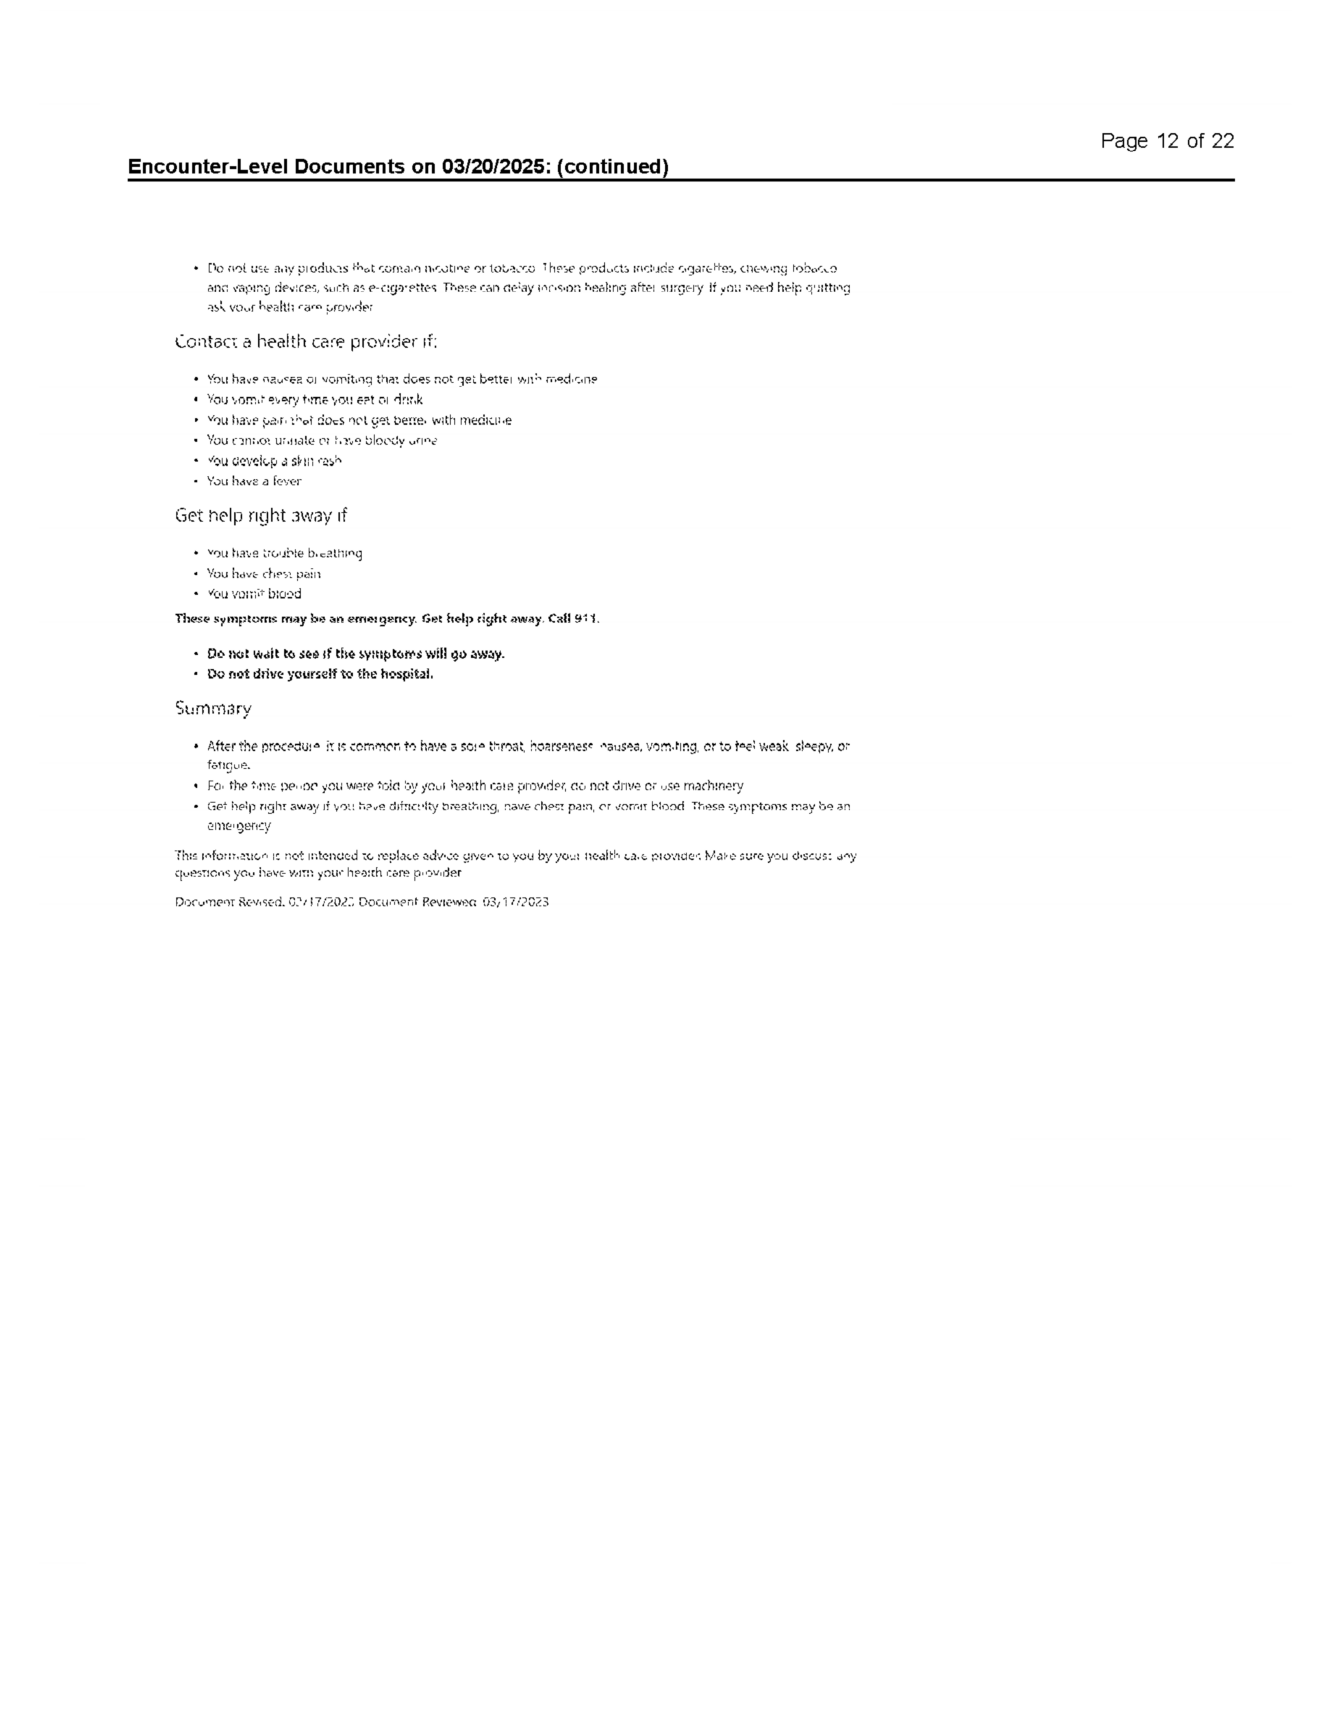

In [18]:
# display the page using matplotlibdef display_page_with_confidence(page, ax=None):
import matplotlib.pyplot as plt

def display_page_with_confidence(page, ax=None):
    # just display the image but make it even bigger
    # i need it zoomed in to see the text
    img = plt.imread(page)
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 22))  # Adjust size as needed

    ax.imshow(img)
    ax.axis('off')
    plt.show()


page="Data/page_1.png"
display_page_with_confidence(page)

#### Zooming in closer

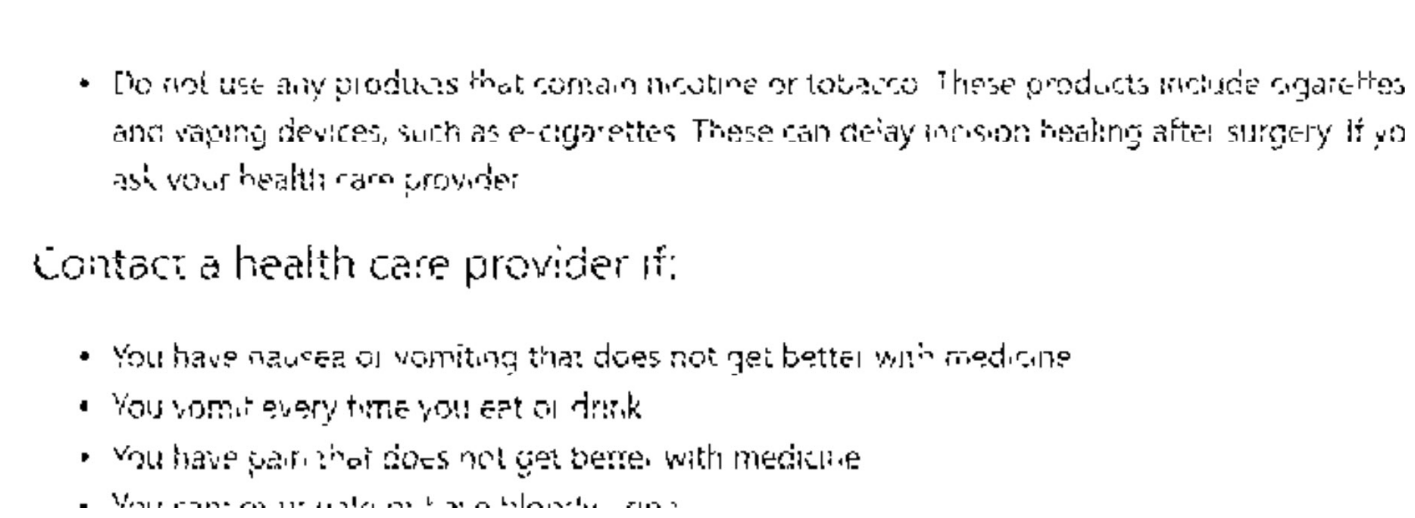

In [19]:
page="Data/zoomed page.jpg"
display_page_with_confidence(page)

### Now we run the illegible page through content Understanding  

In [20]:
# 
file_location = Path("Data/page_34_of_PoC_4.pdf")


if classifier_id_9 and analyzer_id_9A and analyzer_id_9B and analyzer_id_9C:
    print(f"🔨 Using classifier: {classifier_id_9}")
    try:
        # Check if document exists
        if not file_location.exists():
            raise FileNotFoundError(f"Document not found at {file_location}")
    
        # Process with enhanced classifier
        print("📄 Processing document with enhanced classifier")
        print(f"   Document: {file_location.name}")
        print("\n⏳ Processing with classification + field extraction...")

        response = content_understanding_client.begin_classify(classifier_id=classifier_id_9, file_location=str(file_location))
        enhanced_result_compare = content_understanding_client.poll_result(response, timeout_seconds=720,polling_interval_seconds=25)
        
        print("\n✅ Enhanced processing completed!")
        
    except Exception as e:
        print(f"\n❌ Error processing document: {e}")
else:
    print("⚠️  Skipping enhanced classification - enhanced classifier was not created.")

🔨 Using classifier: classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472
📄 Processing document with enhanced classifier
   Document: page_34_of_PoC_4.pdf

⏳ Processing with classification + field extraction...


INFO:content_understanding_client:Analyzing file Data\page_34_of_PoC_4.pdf with classifier_id: classifier_based_on_doc_type_9d3898a76-926b-46cc-b178-a3438fed9472
INFO:content_understanding_client:Request 16318ef4-6d69-430f-85a8-85e77f49c279 in progress ...
INFO:content_understanding_client:Request 16318ef4-6d69-430f-85a8-85e77f49c279 in progress ...
INFO:content_understanding_client:Request result is ready after 25.38 seconds.
INFO:content_understanding_client:Request result is ready after 25.38 seconds.



✅ Enhanced processing completed!


### Now we review the confidence score average for the page

In [21]:
# Call the function to parse and display the results
parse_json_and_display_results(enhanced_result_compare)


📊 DOCUMENT ANALYSIS RESULTS
Total sections(documents) found: 1

DOCUMENT #1
📁 Type of Document: Doctor_Office_Visit_Report
📄 Document Starting Page in Bundle: 1
📄 Document Ending Page in Bundle: 1
📄 Number of Pages in Document: 1
Fields extracted from this Document: 1
📄 Document Title: Encounter-Level Documents on 03/20/2025: (continued)

📊 Confidence Information:
   📄 Word-level confidence - Avg: 0.730, Min: 0.080, Max: 1.000
   📄 Total words with confidence scores: 260


### Detect 

The average confidence is less than 80% (my threshold) and so I execute a remediation workflow.  


### Let's review the extracted content  

Notice how bad the extract word are!

In [26]:
data = enhanced_result_compare
result=enhanced_result_compare.get("result", {})

contents=result['contents'] 
for page in contents[0]['pages']:  
    for line in page['lines']:  
        print(line['content'])  
   

Page 12 of 22
Encounter-Level Documents on 03/20/2025: (continued)
. Do not use any products that coman icative or tobacco These products schade sgarethes, chewing roberta ?
and vaping devices, such as e-cigarettes These can delay ione-on healing after surgery If you need help qatting
MA Your health care provider
Contact a health care provider if:
. You have azucez of vomiting that does not get better with med ons
. You vomit every time you est or drink
. You have par- thot does not get berre, with mediene
. You canvos undate et !Yo bloody urine
. You develop a skin rash
· You have a fever
Get help night 3way if
. vou have trouble breathing
· You have chest pain
· You voma blood
These symptoms may be an emergency. Get help right away. Call 911.
. Do not wait to see if the symptoms will go away.
. Do not drive yourself to the hospital.
Summary
. After the procedure it is common to have a sore throat hoarsenese causes, vomiting, or to the weak sleepy, or
fatigue.
. For the tene peu00 you

### Check for mispelled or unrecognizable words (OK or NOT OK)  

Sentence by sentence

OK Page 12 of 22
NOT OK Encounter-Level Documents on 03/20/2025: (continued).
NOT OK Do not use any products that coman icative or tobacco
NOT OK These products schade sgarethes, chewing roberta ?and vaping devices, such as e-cigarettes
NOT OK These can delay ione-on healing after surgery If you need help qattingMA Your health care provider
NOT OK Contact a health care provider if:. You have azucez of vomiting that does not get better with med ons.
NOT OK You vomit every time you est or drink.
NOT OK You have par- thot does not get berre, with mediene.
NOT OK You canvos undate et !Yo bloody urine.
OK You develop a skin rash·
OK You have a fever
NOT OK Get help night 3way if. vou have trouble breathing·
OK You have chest pain·
NOT OK You voma bloodThese symptoms may be an emergency.
OK Get help right away. Call 911..
OK Do not wait to see if the symptoms will go away..
OK Do not drive yourself to the hospital.
NOT OK Summary. After the procedure it is common to have a sore throat hoarsenese causes, vomiting, or to the weak sleepy, orfatigue..
NOT OK For the tene peu00 you were told by your health care provider, do not drive or use machinery.
OK Get help right away if you have difficulty breathing, nave chest pain, er comet blood
NOT OK These symptoms may be anemergencyThis information is not intended to replace advice given to you by your health care provider:
NOT OK Make sure you discuss wayquestions you have wam your health care provider
NOT OK Document Rewsed. 03/17/202]
OK Document Reviewed 03/ 17/2023

Total lines: 24
"NOT OK" lines: 14

Percentage calculation:
(14 / 24) * 100 = 58.33%

So, 58.33% of the lines are "NOT OK."

### Detect and Remediate

In the next few cells we are demonstrating how you could use content understanding as your primary OCR service but when a page's confidence score was determined as low you could send the page to an LLM for OCR.  


#### Remediate

If we detected the poor confidence score we could then send the page to an LLM to do the OCR.    

First we convert the page to an image.


In [ ]:
# convert the page to an image 
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
# convert it
doc_path="Data/page_34_of_PoC_4.pdf"
images = convert_from_path(doc_path, 500, poppler_path = r"C:\Repo\content-undertanding-for-claims\poppler-24.08.0\Library\bin")

for i, img in enumerate(images, start=1):  
    img_path = "Data/" + f"page_{i}.png"  
    #delete the file if it exists
    if os.path.exists(img_path):
        os.remove(img_path)
        print(f"Deleted existing file: {img_path}")

    img.save(img_path, "PNG")  

    image_full_path=img_path
    print(f"Image saved to {image_full_path}")

Deleted existing file: Data/page_1.png
Image saved to Data/page_1.png
Image saved to Data/page_1.png


### Now we send it to LLM for OCR

In [ ]:
import os
import base64
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
      
endpoint = os.getenv("ENDPOINT_URL", "https://aiservicespak3.openai.azure.com/")
deployment = os.getenv("DEPLOYMENT_NAME", "gpt-4o")
      
# Initialize Azure OpenAI client with Entra ID authentication
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_endpoint=endpoint,
    azure_ad_token_provider=token_provider,
    api_version="2025-01-01-preview",
)


IMAGE_PATH = image_full_path

encoded_image = base64.b64encode(open(IMAGE_PATH, 'rb').read()).decode('ascii')
chat_prompt = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are an AI assistant that helps people find information."
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "\n"
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                }
            },
            {
                "type": "text",
                "text": "lease OCR this document and return the text back as one field."
            }
        ]
    },
    {
        "role": "assistant",
        "content": [
            {
                "type": "text",
                "text": "- Do not use any products that contain nicotine or tobacco. These products include cigarettes, chewing tobacco, and vaping devices, such as e-cigarettes. These can delay wound healing after surgery. If you need help quitting, ask your health care provider.\n\nContact a health care provider if:\n- You have nausea or vomiting that does not get better with medicine.\n- You vomit severely from one or both ends.\n- You have a fever that does not get better with medicine.\n- You vomit severely or have bloody diarrhea.\n- You develop a skin rash.\n- You have a severe headache.\n\nGet help right away if:\n- You have trouble breathing.\n- You have chest pain.\n- You vomit blood.\n\nThese symptoms may be an emergency. Get help right away. Call 911.\n- Do not wait to see if the symptoms will go away.\n- Do not drive yourself to the hospital.\n\nSummary\nAfter the procedure it is common to have a sore throat, hoarseness, nausea, vomiting, or to feel weak, sleepy, or fatigue.\nFor the first 24 hours after you were told by your health care provider, do not drive or use machinery.\nGet help right away if you have difficulty breathing, have chest pain, or vomit blood. These symptoms may be an emergency.\n\nThis information is not intended to replace advice given to you by your health care provider. Make sure you discuss any questions you have with your health care provider.\n\nDocument Revised: 03/17/2023; Document Reviewed: 03/17/2023\nElsevier. Higher Education © 2024 Elsevier Inc.\n\nOsborne, Karen Sue DOB 11/22/1953 Unofficial Copy of Medical Record Encounter-Level Documents on 03/20/2025 (continued) Page 12 of 22\n\nKaren S. Osborne (CSN: 91216529567) (MRN: 8914858997) - Printed at 3/20/2025 1:20 PM Page 8 of 12\n\nOsborne, Karen Sue (MR # 8914858997) Printed by Babb, Jessica, MA [5030388] at 4/15/2025 3:20 PM Encounter Date 02/28/2025"
            }
        ]
    }
]

# Include speech result if speech is enabled
messages = chat_prompt

completion = client.chat.completions.create(
    model=deployment,
    messages=messages,
    max_tokens=1638,
    temperature=0.7,
    top_p=0.95,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None,
    stream=False
)

# print the content
print(completion.choices[0].message.content)


INFO:azure.identity._credentials.environment:No environment configuration found.
INFO:azure.identity._credentials.managed_identity:ManagedIdentityCredential will use IMDS
INFO:azure.identity._credentials.managed_identity:ManagedIdentityCredential will use IMDS
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.0 Python/3.13.5 (Windows-2022Server-10.0.20348-SP0)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.25.0 Python/3.13.5 (Windows-2022Server-10.0.20348-SP0)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response stat

- Do not use any products that contain nicotine or tobacco. These products include cigarettes, chewing tobacco, and vaping devices, such as e-cigarettes. These can delay wound healing after surgery. If you need help quitting, ask your health care provider.

Contact a health care provider if:
- You have nausea or vomiting that does not get better with medicine.
- You vomit severely from one or both ends.
- You have a fever that does not get better with medicine.
- You vomit severely or have bloody diarrhea.
- You develop a skin rash.
- You have a severe headache.

Get help right away if:
- You have trouble breathing.
- You have chest pain.
- You vomit blood.

These symptoms may be an emergency. Get help right away. Call 911.
- Do not wait to see if the symptoms will go away.
- Do not drive yourself to the hospital.

Summary
After the procedure it is common to have a sore throat, hoarseness, nausea, vomiting, or to feel weak, sleepy, or fatigue.
For the first 24 hours after you were told

### Lets review the text from the LLM's OCR  

it looks very good!

In [38]:
# print the content
print(completion.choices[0].message.content)

- Do not use any products that contain nicotine or tobacco. These products include cigarettes, chewing tobacco, and vaping devices, such as e-cigarettes. These can delay wound healing after surgery. If you need help quitting, ask your health care provider.

Contact a health care provider if:
- You have nausea or vomiting that does not get better with medicine.
- You vomit severely from one or both ends.
- You have a fever that does not get better with medicine.
- You vomit severely or have bloody diarrhea.
- You develop a skin rash.
- You have a severe headache.

Get help right away if:
- You have trouble breathing.
- You have chest pain.
- You vomit blood.

These symptoms may be an emergency. Get help right away. Call 911.
- Do not wait to see if the symptoms will go away.
- Do not drive yourself to the hospital.

Summary
After the procedure it is common to have a sore throat, hoarseness, nausea, vomiting, or to feel weak, sleepy, or fatigue.
For the first 24 hours after you were told

### Checking for mis-spelled or unrecognizable words  

#### so we can compare to the "before score"

OK - Do not use any products that contain nicotine or tobacco. These products include cigarettes, chewing tobacco, and vaping devices, such as e-cigarettes. These can delay wound healing after surgery. If you need help quitting, ask your health care provider.

OK Contact a health care provider if: - You have nausea or vomiting that does not get better with medicine. - You vomit severely from one or both ends. - You have a fever that does not get better with medicine. - You vomit severely or have bloody diarrhea. - You develop a skin rash. - You have a severe headache.

OK Get help right away if: - You have trouble breathing. - You have chest pain. - You vomit blood.

OK These symptoms may be an emergency. Get help right away. Call 911. - Do not wait to see if the symptoms will go away. - Do not drive yourself to the hospital.

OK Summary After the procedure it is common to have a sore throat, hoarseness, nausea, vomiting, or to feel weak, sleepy, or fatigue. For the first 24 hours after you were told by your health care provider, do not drive or use machinery. Get help right away if you have difficulty breathing, have chest pain, or vomit blood. These symptoms may be an emergency.

OK This information is not intended to replace advice given to you by your health care provider. Make sure you discuss any questions you have with your health care provider.

OK Document Revised: 03/17/2023; Document Reviewed: 03/17/2023

OK Encounter-Level Documents on 03/20/2025: (continued) Page 12 of 22

Total lines: 13
"NOT OK" lines: 0

Percentage calculation:
(0 / 13) * 100 = 0%



### Here is the scoring  

There are no lines with misspelled or unrecognizable words, so all lines are marked as "OK."

Percentage of "NOT OK" lines: 0%  

Percentage of "OK" lines: 100%

### Summary

There obviously would need to be some orchestration code for this in your  workkflow.

Advantages -  Faster and less expensive that sending every page to the LLM.
              less expensive than manually remediation
              Better overall OCR results

Disadvantages - a more complex worflow